In [4]:
import os, sys, pystan
import numpy as np
from pandas import DataFrame
from scipy.stats import norm

In [6]:
import io

In [8]:
## Define parameters

stan_model = '_hybrid'

# sampling parameters
samples = 3000
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

In [18]:
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tqdm import tqdm
from pandas import DataFrame, concat

In [19]:
# from Sam Zorowitz code -- helper functions
@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def softmax(arr):
    """Scale-robust softmax function"""
    arr = np.exp(arr - np.max(arr))
    return arr / arr.sum()

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

In [20]:
# Hybrid model
class Hybrid(object):
    
    def __init__(self, b1, b2, a1, a2, w, lam, p):
        
        ## Define parameters.
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        self.w = w
        self.l = lam
        self.p = p
        
        ## Initialize Q-values.
        self.MB = None
        self.MF = None
        self.hybrid = None
        
    def train(self, R, T=[[0.7,0.3],[0.3,0.7]], reset=False):
        
        ## Error-catching: rewards.
        R = np.array(R)
        
        ## Error-catching: transition probabilities.
        T = np.array(T)
        
        ## Initialize Q-values.
        if self.MB is None or reset:
            self.MB = 0.5 * np.ones((2,2))
        
        if self.MF is None or reset:
            self.MF = 0.5 * np.ones(2)
            
        
        ## Preallocate space.
        n_trials = R.shape[0]
        Y = np.zeros((n_trials, 2), dtype=int)
        t = np.zeros(n_trials, dtype=int)
        r = np.zeros(n_trials)
            
        for i in range(n_trials):
             
            hybrid1 = self.w * 0.4 * (max(self.MB[1]) - max(self.MB[0])) + (1-self.w)*(self.MF[1] - self.MF[0])
            
            ## Stage 1: Compute choice likelihood.
            if i == 0:
                theta = inv_logit( self.b1 * hybrid1 )
            else:
                m = -1 if Y[i-1,0] == 0 else 1
                theta = inv_logit( self.b1 * hybrid1 + self.p*m )

            ## 1 (0) => pi = -1
            ## 2 (1) => pi = 1
            
            ## Stage 1: Simulate choice.
            Y[i,0] = np.random.binomial(1,theta)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S = np.where(t[i], Y[i,0], 1-Y[i,0]) + 1
            
            hybrid2 = self.MB[S-1,1] - self.MB[S-1,0]
                        
            ## Stage 2: Compute choice likelihood.
            theta = inv_logit( self.b2 * hybrid2 )
            
            ## Stage 2: Simulate choice.
            Y[i,1] = np.random.binomial(1,theta)
            
            ## Stage 2: Observe outcome.
            r[i] = R[i,S-1,Y[i,1]]
    
            ## Update Model-Free values
            self.MF[Y[i,0]] += self.a1 * (self.MB[S-1,Y[i,1]] - self.MF[Y[i,0]]) + self.a1*self.l*(r[i] - self.MB[S-1,Y[i,1]])
            
            ## Update Model-Based values
            self.MB[S-1,Y[i,1]] += self.a2 * (r[i] - self.MB[S-1, Y[i,1]])
            
        return Y, t, r

100%|██████████| 200/200 [00:01<00:00, 137.90it/s]


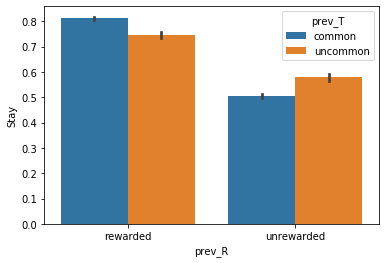

In [21]:
np.random.seed(47404)

data = []
for _ in tqdm(range(200)):
    
    ## Simulate outcomes.
    R = np.random.binomial(1, [[0.5,0.5],[0.5,0.5]], (200,2,2))
    
    ## Initialize agent.
    agent = Hybrid(b1 = 5, b2 = 5, a1 = 0.5, a2 = 0.5, w = 0.5, lam = 1, p = 0.2)

    ## Train agent.
    Y, t, r = agent.train(R)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y[:-1,0] == Y[1:,0]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

In [22]:
## Fit Stan Model

In [23]:
## Train agent.
Y, t, r = agent.train(R)

In [25]:
dd = dict(T=len(t), N=1, Y=Y, O=t, reward=r)

In [32]:
sm = pystan.StanModel(model_code='_hybrid.stan')

ValueError: Failed to parse Stan model 'anon_model_97e8c97ce2eee085d02fc6ca65011635'. Error message:
PARSER FAILED TO PARSE INPUT COMPLETELY
STOPPED AT LINE 1: 
_hybrid.stan





In [29]:
def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel